# Part 05: Tabulate statistics on the street disconntinuties
michael babb  
2025 02 18

In [1]:
# standard
import os

In [2]:
# external
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# custom
import run_constants as rc
from geo_data_io.fc_df_spatial import write_gdf

# output excel file

In [4]:
ofpn = os.path.join(rc.ANALYSIS_OUTPUT_FILE_PATH, rc.S05_ANALYSIS_OUT_FILE_NAME)

In [5]:
e_writer = pd.ExcelWriter(path = ofpn)

# load the street network data

In [6]:
fpn = os.path.join(rc.OUTPUT_FILE_PATH, rc.S05_MISSING_IN_FILE_NAME)

In [7]:
gdf = gpd.read_file(filename = fpn)

In [8]:
gdf.columns

Index(['snd_id', 'ord_street_name', 'ord_street_type', 'ord_stname_type',
       'ord_stname_concat', 'ord_stname_unique', 'ord_stname_type_group',
       'ord_street_type_rank', 'snd_group', 'group_id', 'city_sector',
       'city_sector_group', 'street_status', 'sn_id', 'en_id', 'dist',
       'dist_miles', 'geometry'],
      dtype='object')

In [9]:
gdf.shape

(29776, 18)

In [10]:
gdf['n_segments'] = int(1)

In [11]:
# add text descriptions for the street type categories
street_status_dict = {0:'continuous_street',
                1:'discontinuous_street',
                2:'added_street: within-sector',
                3:'added_street: cross-sector'}

In [12]:
gdf['street_status_desc'] = gdf['street_status'].map(street_status_dict)

In [13]:
# number of segments
gdf['street_status_desc'].value_counts()

street_status_desc
discontinuous_street           21938
continuous_street               3812
added_street: within-sector     3616
added_street: cross-sector       410
Name: count, dtype: int64

In [14]:
# which street name columns feature ''?
gdf.columns

Index(['snd_id', 'ord_street_name', 'ord_street_type', 'ord_stname_type',
       'ord_stname_concat', 'ord_stname_unique', 'ord_stname_type_group',
       'ord_street_type_rank', 'snd_group', 'group_id', 'city_sector',
       'city_sector_group', 'street_status', 'sn_id', 'en_id', 'dist',
       'dist_miles', 'geometry', 'n_segments', 'street_status_desc'],
      dtype='object')

In [15]:
'' in gdf['ord_stname_concat'].unique().tolist()


False

In [16]:
'' in gdf['ord_stname_unique'].unique().tolist()

False

In [17]:
check_df = gdf.loc[(gdf['ord_stname_unique'] == '') &
                (gdf['street_status'] == 2), :]

In [18]:
check_df.head()

,snd_id,ord_street_name,ord_street_type,ord_stname_type,ord_stname_concat,ord_stname_unique,ord_stname_type_group,ord_street_type_rank,snd_group,group_id,city_sector,city_sector_group,street_status,sn_id,en_id,dist,dist_miles,geometry,n_segments,street_status_desc


# q0: basic tabulations

In [19]:
# uniquely named roads in the study areas
gdf.loc[gdf['street_status'].isin([0, 1]), 'ord_stname_concat'].unique().shape

(2453,)

In [20]:
gdf['n_segments'] = int(1)

In [21]:
col_names = ['ord_stname_concat', 'street_status', 'n_segments']
gdf[col_names].drop_duplicates().groupby(by = col_names[1:2]).agg(n_roads = ('n_segments', 'sum'))

,n_roads
street_status,
0,1147
1,1306
2,1102
3,313


In [22]:
col_names = ['ord_stname_concat', 'street_status', 'dist_miles']
gdf.groupby(by = col_names[1:2]).agg(n_miles = ('dist_miles', 'sum'),
                                     n_segments = ('n_segments', 'sum'))

,n_miles,n_segments
street_status,,
0,311.945806,3812
1,1578.228198,21938
2,831.454945,3616
3,823.728529,410


In [23]:
# total road miles in the study area
gdf.loc[gdf['street_status'].isin([0, 1]), 'dist_miles'].sum()

np.float64(1890.1740039767046)

In [24]:
# simple count of road miles
col_names = ['street_status_desc', 'dist_miles']
gdf_agg = gdf[col_names].groupby(col_names[:-1]).agg(n_miles = ('dist_miles', 'sum')).reset_index()

In [25]:
# total road miles
gdf_agg.head()

,street_status_desc,n_miles
0,added_street: cross-sector,823.728529
1,added_street: within-sector,831.454945
2,continuous_street,311.945806
3,discontinuous_street,1578.228198


In [26]:
col_names = ['ord_stname_type_group', 'ord_stname_concat', 'street_status_desc', 'n_segments']
gdf_agg = gdf[col_names].drop_duplicates().groupby(col_names[2:-1]).agg(n_roads = ('n_segments', 'sum')).reset_index()

In [27]:
gdf_agg.head()

,street_status_desc,n_roads
0,added_street: cross-sector,313
1,added_street: within-sector,1102
2,continuous_street,1147
3,discontinuous_street,1306


In [28]:
# number of added segments
gdf['street_status_desc'].value_counts()

street_status_desc
discontinuous_street           21938
continuous_street               3812
added_street: within-sector     3616
added_street: cross-sector       410
Name: count, dtype: int64

In [29]:
# within-sector: average number of segments added per uniquely named road
3617 / 1103

3.2792384406165005

In [30]:
410 / 313

1.3099041533546325

# q1: are cross-sector added streets correct?

In [31]:
gdf.columns

Index(['snd_id', 'ord_street_name', 'ord_street_type', 'ord_stname_type',
       'ord_stname_concat', 'ord_stname_unique', 'ord_stname_type_group',
       'ord_street_type_rank', 'snd_group', 'group_id', 'city_sector',
       'city_sector_group', 'street_status', 'sn_id', 'en_id', 'dist',
       'dist_miles', 'geometry', 'n_segments', 'street_status_desc'],
      dtype='object')

In [32]:
col_names = ['ord_stname_type_group', 'street_status', 'n_segments']

In [33]:
# pivot
gdf_agg = pd.pivot_table(data = gdf, values = 'n_segments', index = ['ord_stname_type_group'],
                         columns = ['street_status'], aggfunc='sum', fill_value=0)

In [34]:
# rename columns
gdf_agg.columns = ['ss_' + str(x) for x in range(0, 4)]

In [35]:
gdf_agg = gdf_agg.reset_index()

In [36]:
# perform a series of tests to identify the multi_sector street
gdf_agg['is_multi_sector'] = int(0)

In [37]:
gdf_agg.loc[gdf_agg['ord_stname_type_group'].str.find('_') > 0, 'is_multi_sector'] = int(1)

In [38]:
# false negatives: an added segment is not marked cross-sector when it should be
gdf_agg['check_street_fn'] = int(0)

In [39]:
gdf_agg.loc[(gdf_agg['is_multi_sector'] == 1) &
            (gdf_agg['ss_3'] == 0), 'check_street_fn'] = int(1)

In [40]:
gdf_agg['check_street_fn'].sum()

np.int64(76)

In [41]:
# false positives: an added segment is marked cross-sector when it should not be
gdf_agg['check_street_fp'] = int(0)
gdf_agg.loc[(gdf_agg['is_multi_sector'] == 0) &
            (gdf_agg['ss_3'] != 0), 'check_street_fp'] = int(1)

In [42]:
gdf_agg['check_street_fp'].sum()

np.int64(0)

In [43]:
# we only have false negatives. Let's highlight those

In [44]:
check_gdf_agg = gdf_agg.loc[(gdf_agg['check_street_fn'] == 1) |
                      (gdf_agg['check_street_fp'] == 1), :]

In [45]:
# export these streets
check_gdf = gdf.loc[gdf['ord_stname_type_group'].isin(check_gdf_agg['ord_stname_type_group']), :]

In [46]:
check_gdf['ord_stname_type_group'].unique().shape

(76,)

In [47]:
# visualize
write_gdf(gdf = check_gdf, output_file_path=rc.OUTPUT_FILE_PATH, output_file_name=rc.S05_STREET_CONNECTION_CHECK_FILE_NAME)

In [48]:
# okay, after looking at these segments in qGIS - they appear to be correct. 
# this is because the existing street crosses from one sector of the city to 
# another, but the added segments are all within-sector. So in a way, by a
# strict definition, these are false negatives, but these streets are correct. 

# q2: what street name - excluding direction - has the most street types?

In [49]:
col_names = ['ord_street_name', 'ord_street_type', 'n_segments']

In [50]:
gdf_agg = gdf.loc[gdf['street_status'].isin((0,1)), col_names].drop_duplicates()

In [51]:
gdf_pv = pd.pivot_table(data = gdf_agg, values = ['n_segments'], index = 'ord_street_name', columns = ['ord_street_type'], aggfunc = 'sum', fill_value = 0, margins = True).reset_index()

In [52]:
gdf_pv.columns = [''.join(cn).replace('n_segments', '') for cn in gdf_pv.columns]

In [53]:
gdf_pv.head()

,ord_street_name,AVE,BLVD,BR,CIR,CT,DR,LN,LOOP,PKWY,PL,PZ,RD,ST,TER,VIEW,WAY,All
0,100TH,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2
1,101ST,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2
2,102ND,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,2
3,103RD,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2
4,104TH,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,4


In [54]:
gdf_pv.to_excel(excel_writer=e_writer, sheet_name = 's_type_count', index = False)

# q3: what street name - excluding type - has the most street connections?

In [55]:
col_names = ['ord_street_name', 'street_status_desc', 'n_segments']
gdf_agg = gdf[col_names].drop_duplicates()

In [56]:
gdf_pv = pd.pivot_table(data = gdf_agg, values = ['n_segments'], index = 'ord_street_name', columns = ['street_status_desc'],
                        aggfunc = 'sum', fill_value = 0, margins = True).reset_index()

In [57]:
gdf_pv.head()

ord_street_name                 n_segments  \
street_status_desc                 added_street: cross-sector   
0                            100TH                          1   
1                            101ST                          1   
2                            102ND                          1   
3                            103RD                          1   
4                            104TH                          1   

                                                                  \
street_status_desc added_street: within-sector continuous_street   
0                                            1                 1   
1                                            1                 1   
2                                            1                 1   
3                                            1                 1   
4                                            1                 1   

                                             
street_status_desc discontinuous_street All  
0                                     1   4  
1                                     1   4  
2                                     1   4  
3                                     1   4  
4                                     1   4

In [58]:
gdf_pv.columns = [''.join(cn).replace('n_segments', '') for cn in gdf_pv.columns]

In [59]:
gdf_pv.columns

Index(['ord_street_name', 'added_street: cross-sector',
       'added_street: within-sector', 'continuous_street',
       'discontinuous_street', 'All'],
      dtype='object')

In [60]:
gdf_pv.head()

,ord_street_name,added_street: cross-sector,added_street: within-sector,continuous_street,discontinuous_street,All
0,100TH,1,1,1,1,4
1,101ST,1,1,1,1,4
2,102ND,1,1,1,1,4
3,103RD,1,1,1,1,4
4,104TH,1,1,1,1,4


In [61]:
gdf_pv.to_excel(excel_writer=e_writer, sheet_name = 'connection_count_by_name', index = False)

# q4: what street name - including direction and type - has the most street connections?

In [62]:
col_names = ['ord_stname_type_group', 'ord_stname_unique', 'ord_stname_concat', 'ord_street_type', 'street_status', 'street_status_desc', 'n_segments']
gdf_agg = gdf[col_names]

In [63]:
gdf_pv = pd.pivot_table(data = gdf, values = ['n_segments'], index = ['ord_stname_unique', 'ord_street_type'],
                        columns = ['street_status_desc'], aggfunc = 'sum', fill_value = 0, margins = True).reset_index()

In [64]:
gdf_pv.columns = [''.join(cn).replace('n_segments', '') for cn in gdf_pv.columns]

In [65]:
gdf_pv.head()

,ord_stname_unique,ord_street_type,added_street: cross-sector,added_street: within-sector,continuous_street,discontinuous_street,All
0,100TH ST NW_N_NE,ST,1,0,0,0,1
1,101ST ST SW_S,ST,1,0,0,0,1
2,102ND ST N_NE,ST,1,0,0,0,1
3,103RD ST NW_N_NE,ST,2,0,0,0,2
4,103RD ST SW_S,ST,1,0,0,0,1


In [66]:
# remove the all row
gdf_pv = gdf_pv.loc[gdf_pv['ord_stname_unique'] != 'All', :]

In [67]:
gdf_pv.shape

(2768, 7)

# q5: what are the streets with at least 10 discontinuities?

In [68]:
gdf_pv.loc[gdf_pv['added_street: within-sector'] >= 13, 'ord_stname_unique'].tolist()

['1ST AVE NW', '2ND AVE NE', '2ND AVE NW', '30TH AVE S', 'W RAYE ST']

In [69]:
gdf_pv.to_excel(excel_writer=e_writer, sheet_name = 'connection_count_full_name', index = False)

In [70]:
# what streets feature the most dicontinuities?
gdf_pv.loc[gdf_pv['added_street: within-sector'] == gdf_pv['added_street: within-sector'].max(), 'ord_stname_unique'].tolist()

['1ST AVE NW']

# q6: what is the ratio of discontinuous to continuous streets?
looking at uniquely named streets

In [71]:
continuous_streets = gdf.loc[gdf['street_status'] == 0, 'ord_stname_unique'].unique().shape[0]
discontinuous_streets = gdf.loc[gdf['street_status'] == 1, 'ord_stname_unique'].unique().shape[0]
total_streets = continuous_streets + discontinuous_streets

In [72]:
continuous_streets / total_streets

0.4680244399185336

In [73]:
discontinuous_streets / total_streets

0.5319755600814664

In [74]:
# 47 percent of named streets are continuous.
# 53 percent of named streets are discontinous.
# this tracks

# q7: which streets feature longer discontinuous portions?

In [75]:
gdf_pv = pd.pivot_table(data = gdf, values = ['dist_miles'], index = ['ord_stname_type_group', 'ord_street_type'],
                        columns = ['street_status_desc'], aggfunc = 'sum', fill_value = 0, margins = True).reset_index()

In [76]:
gdf_pv.columns = [''.join(cn).replace('dist_miles', '') for cn in gdf_pv.columns]

In [77]:
gdf_pv.shape

(1815, 7)

In [78]:
gdf_pv = gdf_pv.loc[gdf_pv['ord_stname_type_group']!= 'All', :].copy()

In [79]:
gdf_pv.shape

(1814, 7)

In [80]:
gdf_pv.head()

,ord_stname_type_group,ord_street_type,added_street: cross-sector,added_street: within-sector,continuous_street,discontinuous_street,All
0,100TH PL NW,PL,0.000000,0.000000,0.201049,0.000000,0.201049
1,100TH PL SW,PL,0.000000,0.000000,0.035254,0.000000,0.035254
2,100TH ST NW_N_NE,ST,0.307315,0.653439,0.000000,4.535595,5.496349
3,100TH ST SW_S,ST,0.000000,0.761244,0.000000,2.970913,3.732157
4,101ST PL SW,PL,0.000000,0.000000,0.034279,0.000000,0.034279


In [81]:
gdf_pv['longer_added'] = int(0) # street is complete
gdf_pv.loc[(gdf_pv['continuous_street'] == 0) & (gdf_pv['added_street: within-sector'] <= gdf_pv['discontinuous_street']), 'longer_added'] = int(1)
gdf_pv.loc[(gdf_pv['continuous_street'] == 0) & (gdf_pv['added_street: within-sector'] > gdf_pv['discontinuous_street']), 'longer_added'] = int(2)

In [82]:
gdf_pv['longer_added'].value_counts()

longer_added
0    1114
1     543
2     157
Name: count, dtype: int64

In [83]:
gdf_pv.to_excel(excel_writer=e_writer, sheet_name = 'distance_full_name', index = False)

In [84]:
# road miles on streets with at least one added segment
split_streets = gdf_pv['discontinuous_street'].sum()
split_streets

np.float64(1578.228198275947)

In [85]:
# road miles on streets with no added segments
continuous_streets = gdf_pv['continuous_street'].sum()
continuous_streets

np.float64(311.94580570075755)

In [86]:
split_streets / (split_streets + continuous_streets)

np.float64(0.8349645032444314)

In [87]:
continuous_streets / (split_streets + continuous_streets)

np.float64(0.1650354967555686)

In [88]:
# 84 percent of road miles are multi-segments streets
# 16 percent of road miles are single segment streets

# q8: tabulate distances and distributions by street type

In [89]:
st_type_df = pd.pivot_table(data = gdf, index = ['ord_street_type'],
                         columns = ['street_status_desc'], values = ['dist_miles'],
                        aggfunc='sum', fill_value = 0).reset_index()



In [90]:
st_type_df.columns = [''.join(cn).replace('dist_miles', '') for cn in st_type_df.columns]

In [91]:
st_type_df.shape

(16, 5)

In [92]:
st_type_df.head()

,ord_street_type,added_street: cross-sector,added_street: within-sector,continuous_street,discontinuous_street
0,AVE,560.253713,431.877647,72.647575,857.534570
1,BLVD,0.046053,0.467329,16.408015,8.648006
2,BR,0.000000,0.000000,4.212091,0.000000
3,CIR,0.000000,0.000000,0.698582,0.000000
4,CT,3.848201,0.022490,4.254737,0.218229


In [93]:
# now, melt
st_type_df_melt = pd.melt(frame = st_type_df, id_vars = ['ord_street_type'],
                          var_name = 'street_status_desc',
                          value_name = 'total_miles')

In [94]:
st_type_df_melt.head()

,ord_street_type,street_status_desc,total_miles
0,AVE,added_street: cross-sector,560.253713
1,BLVD,added_street: cross-sector,0.046053
2,BR,added_street: cross-sector,0.000000
3,CIR,added_street: cross-sector,0.000000
4,CT,added_street: cross-sector,3.848201


In [95]:
col_names = ['ord_street_type', 'street_status_desc', 'dist_miles']

In [96]:
ds_st_df = gdf[col_names].groupby(col_names[:-1]).describe().reset_index()

In [97]:
ds_st_df.head()

ord_street_type           street_status_desc dist_miles                      \
                                                    count      mean       std   
0             AVE   added_street: cross-sector      193.0  2.902869  2.786502   
1             AVE  added_street: within-sector     1728.0  0.249929  0.402936   
2             AVE            continuous_street      906.0  0.080185  0.058779   
3             AVE         discontinuous_street    10531.0  0.081430  0.046233   
4            BLVD   added_street: cross-sector        1.0  0.046053       NaN   

                                                      
        min       25%       50%       75%        max  
0  0.007820  0.520193  1.504484  4.799009  11.127778  
1  0.002857  0.030614  0.095037  0.269936   3.739595  
2  0.003313  0.045066  0.067970  0.099905   0.639583  
3  0.001535  0.050360  0.069714  0.122449   0.633067  
4  0.046053  0.046053  0.046053  0.046053   0.046053

In [98]:
ds_st_df.columns =  [''.join(cn).replace('dist_miles', '') for cn in ds_st_df.columns]

In [99]:
ds_st_df.head()

,ord_street_type,street_status_desc,count,mean,std,min,25%,50%,75%,max
0,AVE,added_street: cross-sector,193.0,2.902869,2.786502,0.007820,0.520193,1.504484,4.799009,11.127778
1,AVE,added_street: within-sector,1728.0,0.249929,0.402936,0.002857,0.030614,0.095037,0.269936,3.739595
2,AVE,continuous_street,906.0,0.080185,0.058779,0.003313,0.045066,0.067970,0.099905,0.639583
3,AVE,discontinuous_street,10531.0,0.081430,0.046233,0.001535,0.050360,0.069714,0.122449,0.633067
4,BLVD,added_street: cross-sector,1.0,0.046053,NaN,0.046053,0.046053,0.046053,0.046053,0.046053


In [100]:
temp_ds_st_df = ds_st_df.loc[ds_st_df['street_status_desc'] == 'added_street', :].copy()

In [101]:
temp_ds_st_df = temp_ds_st_df.drop(labels = 'std', axis = 1)

In [102]:
temp_ds_st_df = temp_ds_st_df.sort_values(by = ['count'], ascending = False)

In [103]:
temp_ds_st_df.to_excel(excel_writer=e_writer, sheet_name = 'added_street_count', index = False)

In [104]:
st_type_df_melt.head()

,ord_street_type,street_status_desc,total_miles
0,AVE,added_street: cross-sector,560.253713
1,BLVD,added_street: cross-sector,0.046053
2,BR,added_street: cross-sector,0.000000
3,CIR,added_street: cross-sector,0.000000
4,CT,added_street: cross-sector,3.848201


In [105]:
ds_st_df.head()

,ord_street_type,street_status_desc,count,mean,std,min,25%,50%,75%,max
0,AVE,added_street: cross-sector,193.0,2.902869,2.786502,0.007820,0.520193,1.504484,4.799009,11.127778
1,AVE,added_street: within-sector,1728.0,0.249929,0.402936,0.002857,0.030614,0.095037,0.269936,3.739595
2,AVE,continuous_street,906.0,0.080185,0.058779,0.003313,0.045066,0.067970,0.099905,0.639583
3,AVE,discontinuous_street,10531.0,0.081430,0.046233,0.001535,0.050360,0.069714,0.122449,0.633067
4,BLVD,added_street: cross-sector,1.0,0.046053,NaN,0.046053,0.046053,0.046053,0.046053,0.046053


In [106]:
# join to get total miles and summary statistics
ds_st_df = pd.merge(left = st_type_df_melt, right = ds_st_df, how = 'left')

In [107]:
ds_st_df.head()

,ord_street_type,street_status_desc,total_miles,count,mean,std,min,25%,50%,75%,max
0,AVE,added_street: cross-sector,560.253713,193.0,2.902869,2.786502,0.007820,0.520193,1.504484,4.799009,11.127778
1,BLVD,added_street: cross-sector,0.046053,1.0,0.046053,NaN,0.046053,0.046053,0.046053,0.046053,0.046053
2,BR,added_street: cross-sector,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CIR,added_street: cross-sector,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CT,added_street: cross-sector,3.848201,1.0,3.848201,NaN,3.848201,3.848201,3.848201,3.848201,3.848201


In [108]:
ds_st_df.columns

Index(['ord_street_type', 'street_status_desc', 'total_miles', 'count', 'mean',
       'std', 'min', '25%', '50%', '75%', 'max'],
      dtype='object')

In [109]:
for cn in ds_st_df.columns:
    if ds_st_df[cn].dtype == 'float64':
        ds_st_df[cn] = ds_st_df[cn].fillna(0)

In [110]:
ds_st_df = ds_st_df.sort_values(by = ['ord_street_type', 'street_status_desc'])

In [111]:
ds_st_df['street_status_desc'] = ds_st_df['street_status_desc'].str.replace('_street', '')

In [112]:
# set index

In [113]:
ds_st_df = ds_st_df.set_index(keys = ['ord_street_type', 'street_status_desc'])

In [114]:
# reorder columns
col_names = ['count', 'min', '25%', '50%', 'mean', '75%', 'max', 'total_miles']
ds_st_df = ds_st_df[col_names]

In [115]:
ds_st_df.to_excel(excel_writer=e_writer, sheet_name = 'sum_stats', index = True)
                  

In [116]:
e_writer.close()

In [117]:
ds_st_df.head()

count       min       25%       50%  \
ord_street_type street_status_desc                                            
AVE             added: cross-sector     193.0  0.007820  0.520193  1.504484   
                added: within-sector   1728.0  0.002857  0.030614  0.095037   
                continuous              906.0  0.003313  0.045066  0.067970   
                discontinuous         10531.0  0.001535  0.050360  0.069714   
BLVD            added: cross-sector       1.0  0.046053  0.046053  0.046053   

                                          mean       75%        max  \
ord_street_type street_status_desc                                    
AVE             added: cross-sector   2.902869  4.799009  11.127778   
                added: within-sector  0.249929  0.269936   3.739595   
                continuous            0.080185  0.099905   0.639583   
                discontinuous         0.081430  0.122449   0.633067   
BLVD            added: cross-sector   0.046053  0.046053   0.046053   

                                      total_miles  
ord_street_type street_status_desc                 
AVE             added: cross-sector    560.253713  
                added: within-sector   431.877647  
                continuous              72.647575  
                discontinuous          857.534570  
BLVD            added: cross-sector      0.046053

# q9: 10 longest added streets by cross-sector and within-sector

In [118]:
wms_gdf = gdf.loc[gdf['street_status'].isin([2,3]), :].copy()

In [119]:
wms_gdf['dist_rank'] = wms_gdf.groupby('street_status')['dist'].rank(method = 'dense', ascending = False)

In [120]:
wms_gdf.loc[(wms_gdf['dist_rank'] <= 10) &
            (wms_gdf['street_status'] == 2), 'ord_stname_unique'].tolist()

['S 105TH ST',
 'S 106TH ST',
 'S 112TH ST',
 'S 116TH ST',
 '11TH AVE S',
 '12TH AVE SW',
 '33RD AVE SW',
 '51ST AVE SW',
 '7TH PL S',
 '9TH AVE S']

# q10: histogram of all added streets

In [121]:
# log transform the distance in miles to prep for plotting
wms_gdf['dist_miles_log'] = np.log10(wms_gdf['dist_miles'])

In [122]:
wms_gdf['dist_miles_log'].describe()

count    4026.000000
mean       -0.925392
std         0.660910
min        -3.128428
25%        -1.452504
50%        -0.984796
75%        -0.462599
max         1.046408
Name: dist_miles_log, dtype: float64

In [123]:
# compute summary stats and create a dataframe
# the ds_df will hold values of interest to plot and plotting keywords for 
# those values
ds_df_list = []
for ss in [2,3]:
    ds_df = wms_gdf.loc[wms_gdf['street_status'] == ss, 'dist_miles'].describe().to_frame().reset_index(names = ['stat'])
    ds_df['street_status'] = ss
    ds_df_list.append(ds_df)
ds_df = pd.concat(ds_df_list)

In [124]:
ds_df.tail()

,stat,dist_miles,street_status
3,min,0.007820,3
4,25%,0.465272,3
5,50%,1.086217,3
6,75%,2.666548,3
7,max,11.127778,3


In [125]:
# remove the count and the standard deviation - not useful for plotting
ds_df = ds_df.loc[-ds_df['stat'].isin(['count', 'std']), :]

In [126]:
# add the 10th, 95th, and 99th precentiles
temp_stat_df_list = []
for ss in [2,3]:
    temp_values = wms_gdf.loc[wms_gdf['street_status'] == ss, 'dist_miles'].to_numpy()
    temp_stat_records = [
        ['10%', np.quantile(a = temp_values, q = 0.10), ss],
        ['95%', np.quantile(a = temp_values, q = 0.95), ss],
        ['99%', np.quantile(a = temp_values, q = 0.99), ss]
    ]
    temp_stat_df = pd.DataFrame(data = temp_stat_records, columns = ds_df.columns)
    temp_stat_df_list.append(temp_stat_df)

temp_stat_df = pd.concat(temp_stat_df_list)



In [127]:
# combine
ds_df = pd.concat(objs = [ds_df, temp_stat_df], axis = 0)

In [128]:
ds_df = ds_df.sort_values(by = ['street_status', 'dist_miles'])

In [129]:
ds_df['dist_miles_log'] = ds_df['dist_miles'].map(lambda x: np.log10(x))

In [130]:
# the color of the lines to add
ds_df['color_list'] = 'black'

In [131]:
# convert to feet to help with labeling
ds_df['dist_feet'] = ds_df['dist_miles'] * 5280

In [132]:
display(ds_df)

,stat,dist_miles,street_status,dist_miles_log,color_list,dist_feet
3,min,0.000744,2,-3.128428,black,3.928314
0,10%,0.018308,2,-1.737366,black,96.664660
4,25%,0.031739,2,-1.498408,black,167.581519
5,50%,0.084869,2,-1.071253,black,448.106175
1,mean,0.229938,2,-0.638390,black,1214.071380
6,75%,0.251241,2,-0.599909,black,1326.552755
1,95%,0.963412,2,-0.016188,black,5086.813317
2,99%,1.880795,2,0.274341,black,9930.598046
7,max,4.973674,2,0.696677,black,26261.000182
3,min,0.007820,3,-2.106767,black,41.292065


In [133]:
# this is the horizontal alignment of each piece of added text
ss_2_text_ha = ['left', 'center',  'center', 'right', 'right', 'left', 'center', 'center', 'right'] 
ss_3_text_ha = ['left', 'right',  'center', 'right', 'right', 'left', 'center', 'center', 'right'] 

text_ha = ss_2_text_ha[:]
text_ha.extend(ss_3_text_ha)
ds_df['text_ha'] = text_ha

In [134]:
# the text labels to add
ss_2_text = ['4ft (min.)', '97 ft (10%)', '167 ft (25%)', '448 ft (med.)', '0.23 mi (avg.)', '0.25 mi (75%)', '0.96 mi (95%)', '1.9 mi (99%)', '5 mi (max.)']
ss_3_text = ['42ft (min.)', '557 ft (10%)', '0.47 mi (25%)', '1.1 mi (med.)', '2.0 mi (avg.)', '2.7 mi (75%)', '6.7 mi (95%)', '10.7 mi (99%)', '11 mi (max.)']

text_labels = ss_2_text[:]
text_labels.extend(ss_3_text)
ds_df['text'] = text_labels

In [135]:
# jitter each piece of text by a small amount left or right
ss_2_text_jitter = [0, -.01, 0, .09, 0, 0, -.05, 0, 0]
ss_3_text_jitter = [0, .001, 0, .09, 0, 0, -.05, 0, 0]
text_jitter = ss_2_text_jitter[:]
text_jitter.extend(ss_3_text_jitter)

ds_df['text_jitter'] = text_jitter

In [136]:
# the horizontal position is created from the distance in miles and the text jitter
ds_df['text_x_pos'] = ds_df['dist_miles_log'] + ds_df['text_jitter']

In [137]:
ds_df.head(n=10)

,stat,dist_miles,street_status,dist_miles_log,color_list,dist_feet,text_ha,text,text_jitter,text_x_pos
3,min,0.000744,2,-3.128428,black,3.928314,left,4ft (min.),0.00,-3.128428
0,10%,0.018308,2,-1.737366,black,96.664660,center,97 ft (10%),-0.01,-1.747366
4,25%,0.031739,2,-1.498408,black,167.581519,center,167 ft (25%),0.00,-1.498408
5,50%,0.084869,2,-1.071253,black,448.106175,right,448 ft (med.),0.09,-0.981253
1,mean,0.229938,2,-0.638390,black,1214.071380,right,0.23 mi (avg.),0.00,-0.638390
6,75%,0.251241,2,-0.599909,black,1326.552755,left,0.25 mi (75%),0.00,-0.599909
1,95%,0.963412,2,-0.016188,black,5086.813317,center,0.96 mi (95%),-0.05,-0.066188
2,99%,1.880795,2,0.274341,black,9930.598046,center,1.9 mi (99%),0.00,0.274341
7,max,4.973674,2,0.696677,black,26261.000182,right,5 mi (max.),0.00,0.696677
3,min,0.007820,3,-2.106767,black,41.292065,left,42ft (min.),0.00,-2.106767


..\graphics\histogram_ws_ALL_streets.png


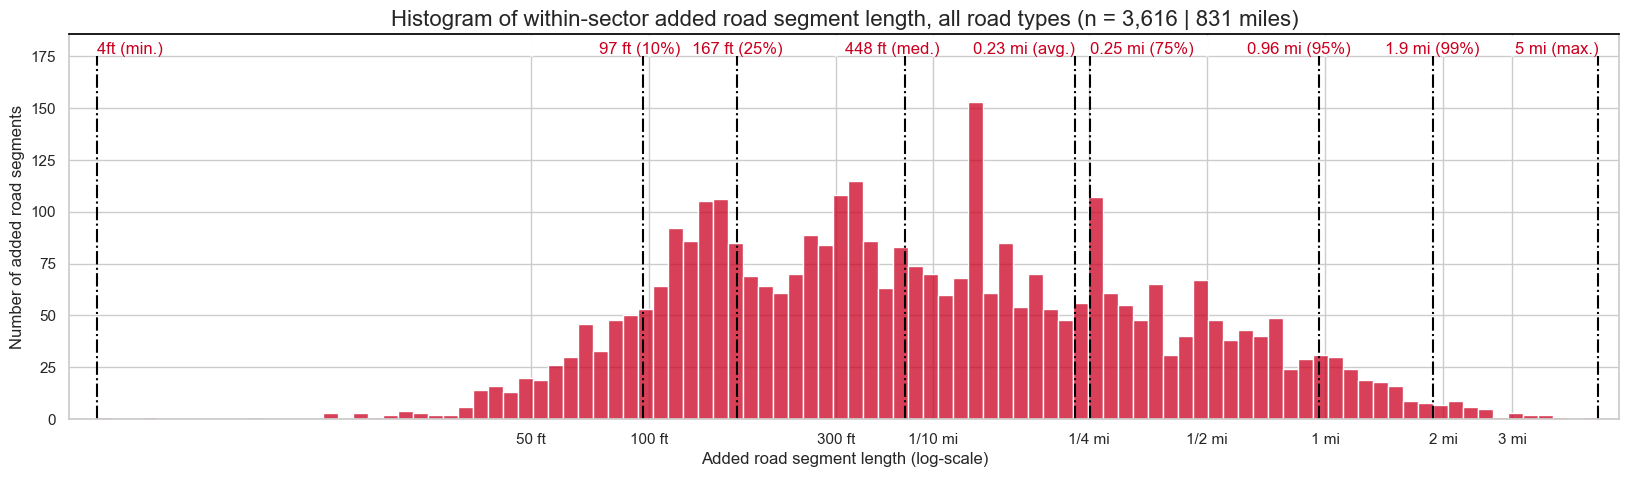

In [138]:
# compute the histogram of the added distribution - for within-sector added streets
working_wms_gdf = wms_gdf.loc[wms_gdf['street_status'] == 2, :]
w_ds_df = ds_df.loc[ds_df['street_status'] == 2, :]
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))

ax.set_ylim(0, 185.6)
ax.set_xlim(-3.2, .75)

my_plot = sns.histplot(data = working_wms_gdf, x = 'dist_miles_log',
                      color='#ca0020', bins = 100)

# set the top part of the plot frame - the spine - to black
ax.spines['top'].set_edgecolor(color = 'black')

y_ticks = list(range(0, 176, 25))
y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_ticks]   

my_plot.set_yticks(ticks = y_ticks)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

# total added streets
n_added = working_wms_gdf.shape[0]
n_added =  f"{n_added:,}"

tot_miles = working_wms_gdf['dist_miles'].sum()
tot_miles = f"{int(round(tot_miles, 0)):,}"

my_title = "Histogram of within-sector added road segment length, all road types (n = {} | {} miles)".format(n_added, tot_miles)

plt.title(label = my_title, fontsize = 16)
plt.xlabel(xlabel = 'Added road segment length (log-scale)')
plt.ylabel(ylabel = "Number of added road segments")

# x tick positions
x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1, 2, 3]
x_ticks = [np.log10(xtl) for xtl in x_tick_labels]

# x tick labels
x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi', '2 mi', '3 mi']

my_plot.set_xticks(ticks = x_ticks)
my_plot.set_xticklabels(labels = x_tick_label_text, rotation=0)

# white out the top portion of the ticks
for xt in x_ticks:
    my_plot.vlines(x = xt, ymin = 175, ymax = 185, color = 'white', linestyles = 'solid', linewidth = 2)

# add vertical lines at some descriptive statistics points
my_plot.vlines(x = w_ds_df['dist_miles_log'], ymin = 0, ymax = 175, color = w_ds_df['color_list'], linestyles = 'dashdot')

# add text for the descriptive stats
for ir, row in w_ds_df.iterrows():
    my_plot.text(x = row['text_x_pos'], y = 176, s = row['text'], horizontalalignment = row['text_ha'], color = '#ca0020')

output_file_name = '..\\graphics\\histogram_ws_ALL_streets.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)
plt.show()

In [139]:
# and there you have it... most added streets are short. 
# 75% of all added streets are 0.25 miles or less. 

In [140]:
working_wms_gdf = wms_gdf.loc[wms_gdf['street_status'] == 3, :]
w_ds_df = ds_df.loc[ds_df['street_status'] == 3, :]


In [141]:
working_wms_gdf['dist_miles_log'].describe()

count    410.000000
mean      -0.036019
std        0.649008
min       -2.106767
25%       -0.332294
50%        0.035917
75%        0.425927
max        1.046408
Name: dist_miles_log, dtype: float64

In [142]:
w_ds_df['dist_miles']

3     0.007820
0     0.105484
4     0.465272
5     1.086217
1     2.009094
6     2.666548
1     6.676756
2    10.639797
7    11.127778
Name: dist_miles, dtype: float64

..\graphics\histogram_cs_ALL_streets.png


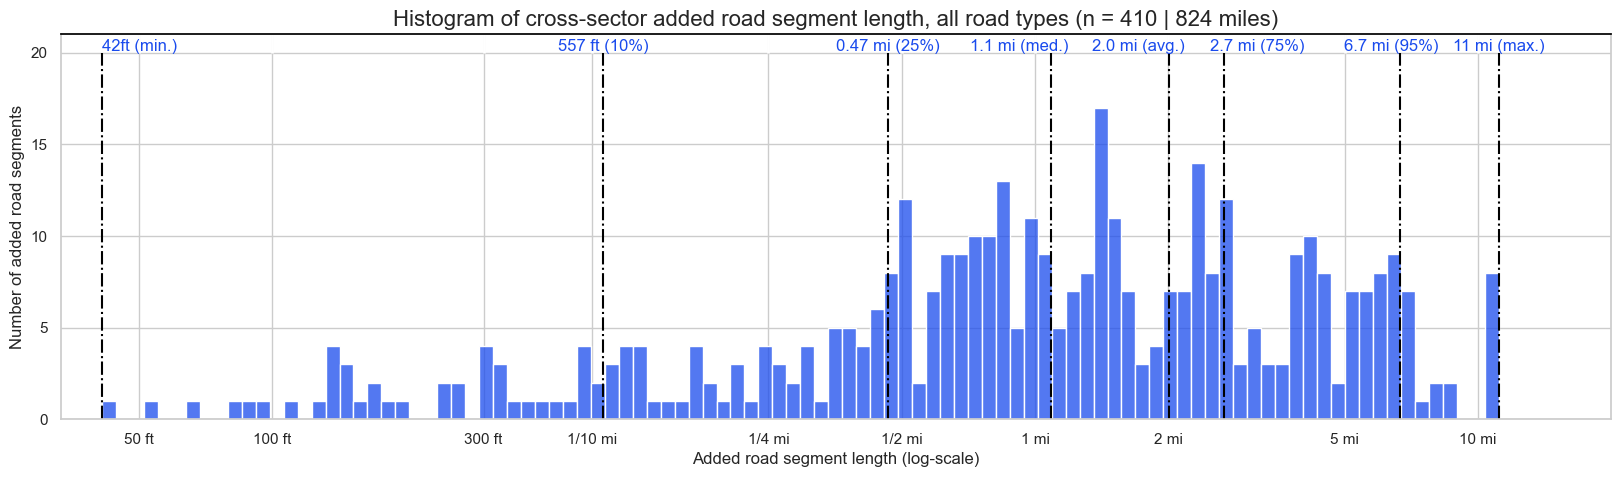

In [143]:
# compute the histogram of the added distribution - for cross-sector added streets
working_wms_gdf = wms_gdf.loc[wms_gdf['street_status'] == 3, :].copy()
w_ds_df = ds_df.loc[(ds_df['street_status'] == 3) & 
                    (ds_df['stat'] != '99%'), :].copy()


sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))

ax.set_ylim(0, 21)
ax.set_xlim(-2.2, 1.3)

my_plot = sns.histplot(data = working_wms_gdf, x = 'dist_miles_log',
                      color='#1a4bed', bins = 100)

# set the top part of the plot frame - the spine - to black
ax.spines['top'].set_edgecolor(color = 'black')

y_ticks = list(range(0, 21, 5))
y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_ticks]   

my_plot.set_yticks(ticks = y_ticks)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

# total added streets
n_added = working_wms_gdf.shape[0]
n_added =  f"{n_added:,}"

tot_miles = working_wms_gdf['dist_miles'].sum()
tot_miles = f"{int(round(tot_miles, 0)):,}"

my_title = "Histogram of cross-sector added road segment length, all road types (n = {} | {} miles)".format(n_added, tot_miles)

plt.title(label = my_title, fontsize = 16)
plt.xlabel(xlabel = 'Added road segment length (log-scale)')
plt.ylabel(ylabel = "Number of added road segments")

# x tick positions
x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1, 2, 5, 10]
x_ticks = [np.log10(xtl) for xtl in x_tick_labels]

# x tick labels
x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi', '2 mi', '5 mi', '10 mi']

my_plot.set_xticks(ticks = x_ticks)
my_plot.set_xticklabels(labels = x_tick_label_text, rotation=0)

# white out the top portion of the ticks
for xt in x_ticks:
    my_plot.vlines(x = xt, ymin = 20, ymax = 25, color = 'white', linestyles = 'solid', linewidth = 2)

# add vertical lines at some descriptive statistics points
my_plot.vlines(x = w_ds_df['dist_miles_log'], ymin = 0, ymax = 20, color = w_ds_df['color_list'], linestyles = 'dashdot')

# add text for the descriptive stats
w_ds_df['text_x_pos'] = w_ds_df['text_x_pos'] + [0,0,0,-.05,-.07,-.03, .03,0]
w_ds_df['text_ha'] = ['left', 'center', 'center', 'right', 'center', 'left', 'center', 'center']
for ir, row in w_ds_df.iterrows():
    my_plot.text(x = row['text_x_pos'], y = 20.1, s = row['text'], horizontalalignment = row['text_ha'], color = '#1a4bed')

output_file_name = '..\\graphics\\histogram_cs_ALL_streets.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)
plt.show()

In [144]:
# average cross sector added segment is 2.0 miles.
# That makes sense as cross-sector connections are going to be longer because 
# of water bodies.

# q11: histogram of each type of street

In [145]:
st_type_df = pd.pivot_table(data = wms_gdf, index = ['ord_street_type'],
                         columns = ['street_status_desc'], values = ['dist_miles'],
                        aggfunc='sum', fill_value = 0).reset_index()

In [146]:
st_type_df.head()

ord_street_type                 dist_miles  \
street_status_desc                 added_street: cross-sector   
0                              AVE                 560.253713   
1                             BLVD                   0.046053   
2                               CT                   3.848201   
3                               DR                   9.561867   
4                               LN                   0.000000   

                                                
street_status_desc added_street: within-sector  
0                                   431.877647  
1                                     0.467329  
2                                     0.022490  
3                                     1.246189  
4                                     2.066653

In [147]:
st_type_df.columns = [''.join(cn).replace('dist_miles', '') for cn in st_type_df.columns]

In [148]:
st_type_df.head()

,ord_street_type,added_street: cross-sector,added_street: within-sector
0,AVE,560.253713,431.877647
1,BLVD,0.046053,0.467329
2,CT,3.848201,0.022490
3,DR,9.561867,1.246189
4,LN,0.000000,2.066653


In [149]:
st_type_df.columns = ['ord_street_type', 'total_miles_cross_sector', 'total_miles_within_sector']

In [150]:
ds_df_list = []
for ss in [2,3]:
    temp_wms_gdf = wms_gdf.loc[wms_gdf['street_status'] == ss, :]
    ds_df = temp_wms_gdf[['ord_street_type', 'dist_miles']].groupby(['ord_street_type'])['dist_miles'].describe().reset_index(names = ['ord_street_type'])
    ds_df['street_status'] = ss
    ds_df_list.append(ds_df)
ds_df = pd.concat(ds_df_list)

In [151]:
ds_df.head()

,ord_street_type,count,mean,std,min,25%,50%,75%,max,street_status
0,AVE,1728.0,0.249929,0.402936,0.002857,0.030614,0.095037,0.269936,3.739595,2
1,BLVD,9.0,0.051925,0.079263,0.001021,0.010911,0.019715,0.046605,0.255118,2
2,CT,1.0,0.022490,NaN,0.022490,0.022490,0.022490,0.022490,0.022490,2
3,DR,14.0,0.089013,0.102982,0.004334,0.029131,0.051434,0.110189,0.383551,2
4,LN,9.0,0.229628,0.321047,0.015234,0.018194,0.039581,0.408942,0.903147,2


## within-sector added streets

In [152]:
w_ds_df = ds_df.loc[ds_df['street_status'] == 2, :]
for ir, row in w_ds_df.iterrows():
    # let's make a graphic showing the distances
    sns.set_theme(style = "whitegrid")
    f, ax = plt.subplots(figsize = (20, 5))

    # set the top part of the plot frame - the spine - to black
    ax.spines['top'].set_edgecolor(color = 'black')

    x_max = row['max']
    ost = row['ord_street_type']    
    
    if x_max > 1:
        xlim_max = .75
    else:
        xlim_max = 0
    ax.set_xlim(-3.2, xlim_max)

    temp_gdf = wms_gdf.loc[(wms_gdf['ord_street_type'] == ost) &
                           (wms_gdf['street_status'] == 2), :]
    my_plot = sns.histplot(data = temp_gdf, x = 'dist_miles_log',
                          color='#ca0020', bins = 100)
    
    # total added streets
    n_added = temp_gdf.shape[0]
    n_added =  f"{n_added:,}"

    tot_miles = temp_gdf['dist_miles'].sum()    
    dist_units = 'miles'
    if tot_miles < .25:
        tot_dist = int(round(temp_gdf['dist'].sum(), 0))
        dist_units = 'feet'        
    elif tot_miles >= .25 and tot_miles <= 5:    
        tot_dist = tot_miles
        tot_dist = round(tot_dist, 2)        
    else:
        tot_dist = int(round(tot_miles, 0))        
        
    my_title =   "Histogram of within-sector added road segment length: {} (n = {} | {} {})".format(ost, n_added, tot_dist, dist_units )
    
    plt.title(label = my_title, fontsize = 16)
    plt.xlabel(xlabel = 'Added road segment length (log-scale)')
    plt.ylabel(ylabel = "Number of added road segments")
    
    if x_max > 1:
        x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1, 2, 3]
        x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi', '2 mi', '3 mi']
    else:
        x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1]
        x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi']
        
    x_ticks = [np.log10(xtl) for xtl in x_tick_labels]
    
    my_plot.set_xticks(ticks = x_ticks)
    my_plot.set_xticklabels(labels = x_tick_label_text, rotation=0)        
    
    output_file_name = '..\\graphics\\histogram_ws_{}.png'.format(row['ord_street_type'])
    output_file_name = os.path.normpath(output_file_name)
    print(output_file_name)
    my_plot.get_figure().savefig(fname = output_file_name)
    plt.close()

..\graphics\histogram_ws_AVE.png
..\graphics\histogram_ws_BLVD.png
..\graphics\histogram_ws_CT.png
..\graphics\histogram_ws_DR.png
..\graphics\histogram_ws_LN.png
..\graphics\histogram_ws_PKWY.png
..\graphics\histogram_ws_PL.png
..\graphics\histogram_ws_RD.png
..\graphics\histogram_ws_ST.png
..\graphics\histogram_ws_WAY.png


## cross-sector added streets

In [153]:
w_ds_df = ds_df.loc[ds_df['street_status'] == 3, :]
for ir, row in w_ds_df.iterrows():
    # let's make a graphic showing the distances
    sns.set_theme(style = "whitegrid")
    f, ax = plt.subplots(figsize = (20, 5))

    # set the top part of the plot frame - the spine - to black
    ax.spines['top'].set_edgecolor(color = 'black')

    x_max = row['max']
    print(x_max)
    ost = row['ord_street_type']    
    
    if x_max > 1:
        xlim_max = 1.2
    else:
        xlim_max = 0
    ax.set_xlim(-3.2, xlim_max)

    temp_gdf = wms_gdf.loc[(wms_gdf['ord_street_type'] == ost) &
                           (wms_gdf['street_status'] == 3), :]
    my_plot = sns.histplot(data = temp_gdf, x = 'dist_miles_log',
                          color='#1a4bed', bins = 100)
    
    # total added streets
    n_added = temp_gdf.shape[0]
    n_added =  f"{n_added:,}"

    tot_miles = temp_gdf['dist_miles'].sum()    
    dist_units = 'miles'
    if tot_miles < .25:
        tot_dist = int(round(temp_gdf['dist'].sum(), 0))
        dist_units = 'feet'        
    elif tot_miles >= .25 and tot_miles <= 5:    
        tot_dist = tot_miles
        tot_dist = round(tot_dist, 2)        
    else:
        tot_dist = int(round(tot_miles, 0))        
        
    my_title =   "Histogram of cross-sector added road segment length: {} (n = {} | {} {})".format(ost, n_added, tot_dist, dist_units )
    
    plt.title(label = my_title, fontsize = 16)
    plt.xlabel(xlabel = 'Added road segment length (log-scale)')
    plt.ylabel(ylabel = "Number of added road segments")
    
    if x_max > 1:
        x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1, 3, 5, 10]
        x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi', '3 mi', '5 mi', '10 mi']
    else:
        x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1]
        x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi']
        
    x_ticks = [np.log10(xtl) for xtl in x_tick_labels]
    
    my_plot.set_xticks(ticks = x_ticks)
    my_plot.set_xticklabels(labels = x_tick_label_text, rotation=0)    
    
    
    output_file_name = '..\\graphics\\histogram_cs_{}.png'.format(row['ord_street_type'])
    output_file_name = os.path.normpath(output_file_name)
    print(output_file_name)
    my_plot.get_figure().savefig(fname = output_file_name)
    plt.close()

11.12777830391803
..\graphics\histogram_cs_AVE.png
0.04605250958975585
..\graphics\histogram_cs_BLVD.png
3.848200891309714
..\graphics\histogram_cs_CT.png
8.793808719286599
..\graphics\histogram_cs_DR.png
2.1419286774069763
..\graphics\histogram_cs_RD.png
8.832586832112682
..\graphics\histogram_cs_ST.png
1.5325142173098012
..\graphics\histogram_cs_WAY.png


# q12: barplot of total added miles

In [154]:
col_names = ['ord_street_type', 'street_status_desc', 'dist_miles']
ds_st_df = gdf[col_names].groupby(col_names[:-1]).agg(n_segments = ('dist_miles', 'size'),
                                                      n_miles = ('dist_miles', 'sum')).reset_index()

In [155]:
ds_st_df.head()

,ord_street_type,street_status_desc,n_segments,n_miles
0,AVE,added_street: cross-sector,193,560.253713
1,AVE,added_street: within-sector,1728,431.877647
2,AVE,continuous_street,906,72.647575
3,AVE,discontinuous_street,10531,857.534570
4,BLVD,added_street: cross-sector,1,0.046053


In [156]:
col_names = ['street_status_desc', 'dist_miles']
all_ds_st_df = gdf[col_names].groupby(col_names[:-1]).agg(n_segments = ('dist_miles', 'size'),
                                                      n_miles = ('dist_miles', 'sum')).reset_index()

In [157]:
all_ds_st_df['ord_street_type'] = 'ALL'

In [158]:
col_names = ['ord_street_type', 'street_status_desc', 'n_segments', 'n_miles']
all_ds_st_df = all_ds_st_df[col_names]

In [159]:
ds_st_df = pd.concat(objs = [all_ds_st_df, ds_st_df])

In [160]:
ds_st_df.head()

,ord_street_type,street_status_desc,n_segments,n_miles
0,ALL,added_street: cross-sector,410,823.728529
1,ALL,added_street: within-sector,3616,831.454945
2,ALL,continuous_street,3812,311.945806
3,ALL,discontinuous_street,21938,1578.228198
0,AVE,added_street: cross-sector,193,560.253713


In [161]:
ds_st_df['n_miles_log'] = np.log(ds_st_df['n_miles'])
ds_st_df['street_status_desc'] = ds_st_df['street_status_desc'].str.replace('_', ' ')

..\graphics\barplot_miles.png


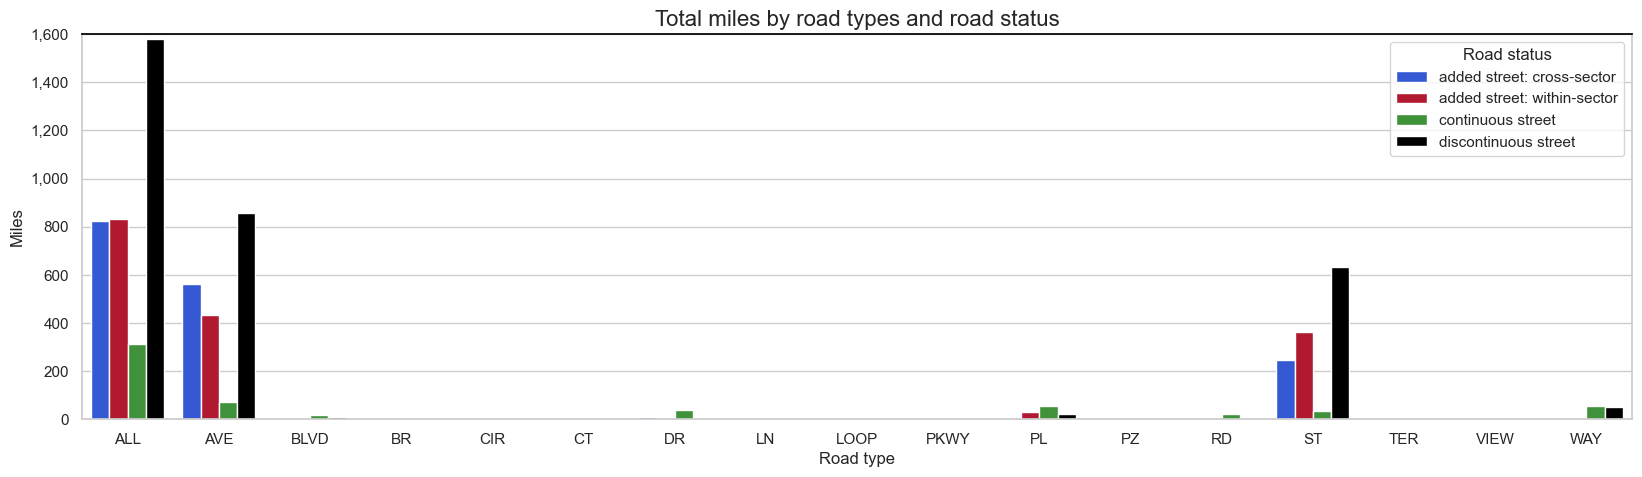

In [162]:
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))
ax.set_ylim(0, 1600)

# these are the same green, black, and red colors used in qGIS. 
my_color_palette = {'continuous street': '#33a02c',
'discontinuous street': '#000000',
'added street: within-sector': '#ca0020',
'added street: cross-sector': '#1a4bed'}

my_plot = sns.barplot(data = ds_st_df, x = 'ord_street_type', y = 'n_miles',
                      hue = 'street_status_desc', palette=my_color_palette)

# set the top part of the plot frame - the spine - to black
ax.spines['top'].set_edgecolor(color = 'black')

y_ticks = list(range(0, 1601, 200))
y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_ticks]   

my_plot.set_yticks(ticks = y_ticks)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

my_title = "Total miles by road types and road status"

plt.title(label = my_title, fontsize = 16)
plt.xlabel(xlabel = 'Road type')
plt.ylabel(ylabel = "Miles")

plt.legend(title='Road status')

output_file_name = '..\\graphics\\barplot_miles.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)
plt.show()

In [163]:
ds_st_df.describe()

,n_segments,n_miles,n_miles_log
count,46.000000,46.000000,46.000000
mean,1294.608696,154.145977,2.101918
std,3823.297341,323.542191,3.040413
min,1.000000,0.015919,-4.140264
25%,6.000000,1.352368,0.293409
50%,73.000000,5.316756,1.670862
75%,524.000000,56.141089,4.027845
max,21938.000000,1578.228198,7.364058


..\graphics\barplot_segment_count.png


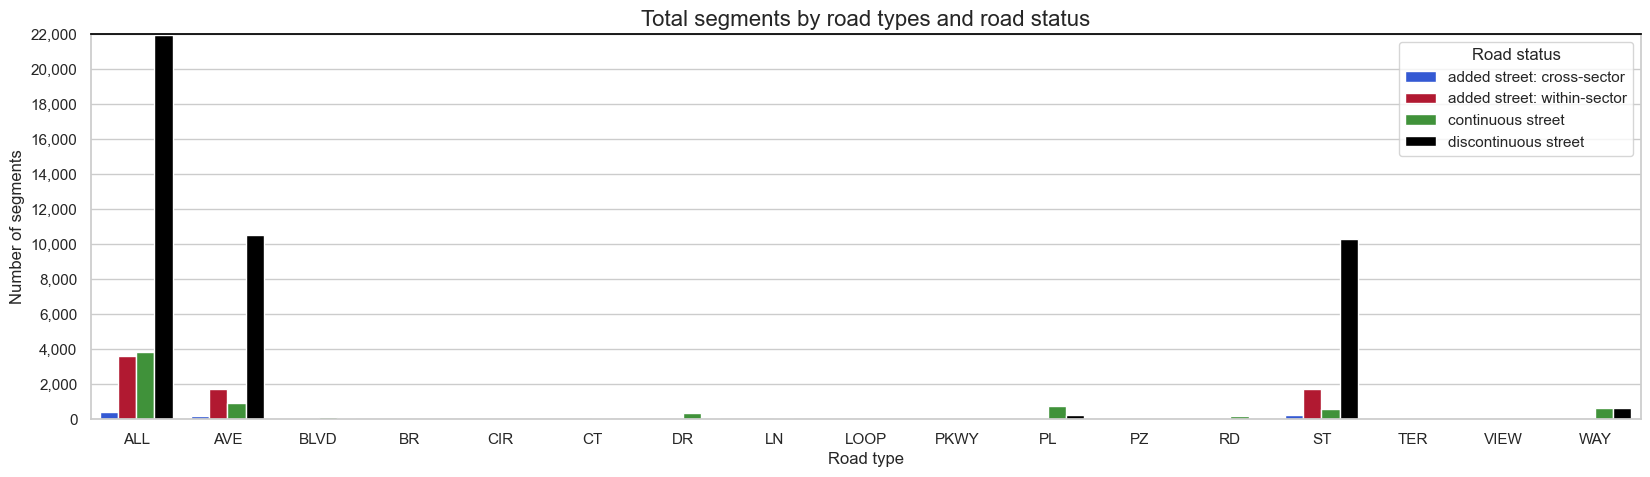

In [164]:
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))
ax.set_ylim(0, 22000)

my_plot = sns.barplot(data = ds_st_df, x = 'ord_street_type', y = 'n_segments',
                      hue = 'street_status_desc', palette=my_color_palette)

# set the top part of the plot frame - the spine - to black
ax.spines['top'].set_edgecolor(color = 'black')

y_ticks = list(range(0, 22001, 2000))
y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_ticks]   

my_plot.set_yticks(ticks = y_ticks)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

my_title = "Total segments by road types and road status"

plt.title(label = my_title, fontsize = 16)
plt.xlabel(xlabel = 'Road type')
plt.ylabel(ylabel = "Number of segments")

plt.legend(title='Road status')

output_file_name = '..\\graphics\\barplot_segment_count.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)
plt.show()

# q13: scatterplot ratio of added streets to existing streets

In [165]:
# select only the discontinuous and added streets
w_gdf = gdf.loc[gdf['street_status'].isin([1,2]), :]

In [166]:
# pivot the data so we can compute the ratio of existing street segments to the added streets
pv_df = pd.pivot_table(data = w_gdf, values = 'dist_miles',index = ['city_sector', 'ord_stname_concat'],
                        columns='street_status_desc',
                        aggfunc='sum',fill_value=0,
                        margins=True).reset_index()
pv_df = pv_df.loc[pv_df['city_sector'] != 'All', :]

In [167]:
pv_df.shape

(1306, 5)

In [168]:
pv_df.head()

street_status_desc,city_sector,ord_stname_concat,added_street: within-sector,discontinuous_street,All
0,CNTR,10TH AVE,0.412324,0.528322,0.940646
1,CNTR,11TH AVE,0.291208,0.818979,1.110187
2,CNTR,12TH AVE,0.000000,1.179729,1.179729
3,CNTR,13TH AVE,0.200588,0.981715,1.182303
4,CNTR,14TH AVE,0.000000,1.181609,1.181609


In [169]:
# rename
pv_df.columns = ['city_sector', 'ord_stname_concat',
                 'added_street_within_sector',
                 'discontinuous_street', 'total_length']

In [170]:
# there are some streets that are discontinuous across sectors
# keep only the streets that are discontinuous within sectors
pv_df = pv_df.loc[pv_df['added_street_within_sector'] != 0, ]

In [171]:
# calculate percentages
col_names = ['added_street_within_sector', 'discontinuous_street']
for cn in col_names:
    ncn = cn + '_per'
    pv_df[ncn] = pv_df[cn] / pv_df['total_length']

In [172]:
# compute the ratio of discontinuous streets to added streets
# values GTE 1 indicate there is more existing street than added street
pv_df['street_ratio_dta'] = pv_df['discontinuous_street'] / pv_df['added_street_within_sector']
# compute the ratio of added streets to discontinuous streets
# values GTE 1 indicate there is more added street than added street
pv_df['street_ratio_atd'] =  pv_df['added_street_within_sector'] / pv_df['discontinuous_street']

In [173]:
# sort
pv_df = pv_df.sort_values(by = ['city_sector', 'street_ratio_atd'],
                          ascending= [True, False]).reset_index(drop = True)
pv_df.shape

(1102, 9)

In [174]:
pv_df.head()

,city_sector,ord_stname_concat,added_street_within_sector,discontinuous_street,total_length,added_street_within_sector_per,discontinuous_street_per,street_ratio_dta,street_ratio_atd
0,CNTR,COMSTOCK ST,0.556985,0.109835,0.666820,0.835285,0.164715,0.197197,5.071083
1,CNTR,39TH AVE,0.450590,0.249468,0.700059,0.643646,0.356354,0.553648,1.806202
2,CNTR,TERRACE ST,0.250940,0.180963,0.431902,0.581010,0.418990,0.721140,1.386694
3,CNTR,RANDOLPH AVE,0.273631,0.226598,0.500229,0.547011,0.452989,0.828115,1.207561
4,CNTR,SMITH ST,0.227889,0.218018,0.445906,0.511068,0.488932,0.956686,1.045275


In [175]:
# log transform the length measurement of each street - this will help with plotting
pv_df['discontinuous_street_log'] = np.log10(pv_df['discontinuous_street'])
pv_df['added_street_within_sector_log'] = np.log10(pv_df['added_street_within_sector'])

In [176]:
# now, let's rank by sector and then overall
# rank of the discontinuous street to the added street
pv_df['street_ratio_dta_rank'] = pv_df.groupby('city_sector')['street_ratio_dta'].rank(method = 'dense', ascending = False).astype(int)
pv_df['ds_per_rank'] = pv_df.groupby('city_sector')['discontinuous_street_per'].rank(method = 'dense', ascending = False).astype(int)
# rank of the added street to the discontinuous street
pv_df['street_ratio_atd_rank'] = pv_df.groupby('city_sector')['street_ratio_atd'].rank(method = 'dense', ascending = False).astype(int)
pv_df['asws_per_rank'] = pv_df.groupby('city_sector')['added_street_within_sector_per'].rank(method = 'dense', ascending = False).astype(int)

In [177]:
pv_df.head()

,city_sector,ord_stname_concat,added_street_within_sector,discontinuous_street,total_length,added_street_within_sector_per,discontinuous_street_per,street_ratio_dta,street_ratio_atd,discontinuous_street_log,added_street_within_sector_log,street_ratio_dta_rank,ds_per_rank,street_ratio_atd_rank,asws_per_rank
0,CNTR,COMSTOCK ST,0.556985,0.109835,0.666820,0.835285,0.164715,0.197197,5.071083,-0.959257,-0.254157,64,64,1,1
1,CNTR,39TH AVE,0.450590,0.249468,0.700059,0.643646,0.356354,0.553648,1.806202,-0.602984,-0.346218,63,63,2,2
2,CNTR,TERRACE ST,0.250940,0.180963,0.431902,0.581010,0.418990,0.721140,1.386694,-0.742411,-0.600431,62,62,3,3
3,CNTR,RANDOLPH AVE,0.273631,0.226598,0.500229,0.547011,0.452989,0.828115,1.207561,-0.644744,-0.562835,61,61,4,4
4,CNTR,SMITH ST,0.227889,0.218018,0.445906,0.511068,0.488932,0.956686,1.045275,-0.661508,-0.642278,60,60,5,5


In [178]:
col_names = ['city_sector',
'ord_stname_concat',
'discontinuous_street',
'added_street_within_sector',
'total_length',
'discontinuous_street_per',
'added_street_within_sector_per',
'street_ratio_dta',
'street_ratio_dta_rank',
'ds_per_rank',
'street_ratio_atd',
'street_ratio_atd_rank',
'asws_per_rank']

In [179]:
# to excel
pv_df[col_names].to_excel('check_ranks.xlsx', index = False)

In [180]:
pv_df['record_count'] = int(1)

In [181]:
# Flag streets that have a street_ratio_dta_hue GTE 1 
# this means that these street feature more existing streets than added streets
# if we want auto colors
pv_df['street_ratio_dta_hue'] = int(0)
pv_df.loc[pv_df['street_ratio_dta'] >= 1, 'street_ratio_dta_hue'] = int(1)

pv_df['street_ratio_dta_colors'] = '#000000'
pv_df.loc[pv_df['street_ratio_dta_hue'] == 0, 'street_ratio_dta_colors'] = '#ca0020'


In [182]:
pv_df.head()

,city_sector,ord_stname_concat,added_street_within_sector,discontinuous_street,total_length,added_street_within_sector_per,discontinuous_street_per,street_ratio_dta,street_ratio_atd,discontinuous_street_log,added_street_within_sector_log,street_ratio_dta_rank,ds_per_rank,street_ratio_atd_rank,asws_per_rank,record_count,street_ratio_dta_hue,street_ratio_dta_colors
0,CNTR,COMSTOCK ST,0.556985,0.109835,0.666820,0.835285,0.164715,0.197197,5.071083,-0.959257,-0.254157,64,64,1,1,1,0,#ca0020
1,CNTR,39TH AVE,0.450590,0.249468,0.700059,0.643646,0.356354,0.553648,1.806202,-0.602984,-0.346218,63,63,2,2,1,0,#ca0020
2,CNTR,TERRACE ST,0.250940,0.180963,0.431902,0.581010,0.418990,0.721140,1.386694,-0.742411,-0.600431,62,62,3,3,1,0,#ca0020
3,CNTR,RANDOLPH AVE,0.273631,0.226598,0.500229,0.547011,0.452989,0.828115,1.207561,-0.644744,-0.562835,61,61,4,4,1,0,#ca0020
4,CNTR,SMITH ST,0.227889,0.218018,0.445906,0.511068,0.488932,0.956686,1.045275,-0.661508,-0.642278,60,60,5,5,1,0,#ca0020


In [183]:
# compute within-sector and citywide totals
sctr_sum_df = pd.pivot_table(data = pv_df, values = 'record_count', index = 'city_sector',
                          columns = 'street_ratio_dta_hue', aggfunc='sum', margins = True,
                          margins_name='City Wide').reset_index()
sctr_sum_df.columns = ['city_sector', 'added_is_gt', 'existing_is_gt', 'total_streets']

col_names = ['added_is_gt', 'existing_is_gt']
for cn in col_names:
    ncn = cn + '_per'
    sctr_sum_df[ncn] = sctr_sum_df[cn] / sctr_sum_df['total_streets']
sctr_sum_df.head()

display(sctr_sum_df)

,city_sector,added_is_gt,existing_is_gt,total_streets,added_is_gt_per,existing_is_gt_per
0,CNTR,6,58,64,0.093750,0.906250
1,E,14,75,89,0.157303,0.842697
2,N,27,86,113,0.238938,0.761062
3,NE,60,119,179,0.335196,0.664804
4,NW,15,82,97,0.154639,0.845361
5,S,112,177,289,0.387543,0.612457
6,SW,49,124,173,0.283237,0.716763
7,W,10,88,98,0.102041,0.897959
8,City Wide,293,809,1102,0.265880,0.734120


In [184]:
pv_df.head()

,city_sector,ord_stname_concat,added_street_within_sector,discontinuous_street,total_length,added_street_within_sector_per,discontinuous_street_per,street_ratio_dta,street_ratio_atd,discontinuous_street_log,added_street_within_sector_log,street_ratio_dta_rank,ds_per_rank,street_ratio_atd_rank,asws_per_rank,record_count,street_ratio_dta_hue,street_ratio_dta_colors
0,CNTR,COMSTOCK ST,0.556985,0.109835,0.666820,0.835285,0.164715,0.197197,5.071083,-0.959257,-0.254157,64,64,1,1,1,0,#ca0020
1,CNTR,39TH AVE,0.450590,0.249468,0.700059,0.643646,0.356354,0.553648,1.806202,-0.602984,-0.346218,63,63,2,2,1,0,#ca0020
2,CNTR,TERRACE ST,0.250940,0.180963,0.431902,0.581010,0.418990,0.721140,1.386694,-0.742411,-0.600431,62,62,3,3,1,0,#ca0020
3,CNTR,RANDOLPH AVE,0.273631,0.226598,0.500229,0.547011,0.452989,0.828115,1.207561,-0.644744,-0.562835,61,61,4,4,1,0,#ca0020
4,CNTR,SMITH ST,0.227889,0.218018,0.445906,0.511068,0.488932,0.956686,1.045275,-0.661508,-0.642278,60,60,5,5,1,0,#ca0020


In [185]:
col_names = ['city_sector', 'added_street_within_sector', 'discontinuous_street', 'total_length']
sctr_mean_df = pv_df[col_names].groupby(col_names[:-3]).agg(added_avg_length = ('added_street_within_sector', 'mean'),
                                                      existing_avg_length = ('discontinuous_street', 'mean'),
                                                      total_avg_length = ('total_length', 'mean')
                                                      ).reset_index()

display(sctr_mean_df)

,city_sector,added_avg_length,existing_avg_length,total_avg_length
0,CNTR,0.167148,0.699919,0.867067
1,E,0.414756,1.102470,1.517225
2,N,0.665375,1.360520,2.025895
3,NE,0.944475,1.580753,2.525227
4,NW,0.372054,1.329486,1.701539
5,S,1.124205,1.321449,2.445654
6,SW,0.827981,1.431721,2.259702
7,W,0.360925,1.060645,1.421571


In [186]:
col_names = ['added_street_within_sector', 'discontinuous_street', 'total_length']
tot_mean_df = pv_df[col_names].mean(axis = 0).to_numpy().reshape((1,3))
tot_mean_df = pd.DataFrame(data = tot_mean_df, 
                           columns = col_names)
tot_mean_df.columns = sctr_mean_df.columns.tolist()[1:]

tot_mean_df['city_sector'] = 'City Wide'

tot_mean_df = tot_mean_df[sctr_mean_df.columns].copy()

#tot_mean_df.shape
sctr_mean_df = pd.concat(objs = [sctr_mean_df, tot_mean_df])

display(sctr_mean_df)


,city_sector,added_avg_length,existing_avg_length,total_avg_length
0,CNTR,0.167148,0.699919,0.867067
1,E,0.414756,1.102470,1.517225
2,N,0.665375,1.360520,2.025895
3,NE,0.944475,1.580753,2.525227
4,NW,0.372054,1.329486,1.701539
5,S,1.124205,1.321449,2.445654
6,SW,0.827981,1.431721,2.259702
7,W,0.360925,1.060645,1.421571
0,City Wide,0.754496,1.308619,2.063115


In [187]:
sctr_df = pd.merge(left = sctr_sum_df, right = sctr_mean_df)

In [188]:
sctr_df.head()

,city_sector,added_is_gt,existing_is_gt,total_streets,added_is_gt_per,existing_is_gt_per,added_avg_length,existing_avg_length,total_avg_length
0,CNTR,6,58,64,0.093750,0.906250,0.167148,0.699919,0.867067
1,E,14,75,89,0.157303,0.842697,0.414756,1.102470,1.517225
2,N,27,86,113,0.238938,0.761062,0.665375,1.360520,2.025895
3,NE,60,119,179,0.335196,0.664804,0.944475,1.580753,2.525227
4,NW,15,82,97,0.154639,0.845361,0.372054,1.329486,1.701539


In [189]:
sctr_df.tail()

,city_sector,added_is_gt,existing_is_gt,total_streets,added_is_gt_per,existing_is_gt_per,added_avg_length,existing_avg_length,total_avg_length
4,NW,15,82,97,0.154639,0.845361,0.372054,1.329486,1.701539
5,S,112,177,289,0.387543,0.612457,1.124205,1.321449,2.445654
6,SW,49,124,173,0.283237,0.716763,0.827981,1.431721,2.259702
7,W,10,88,98,0.102041,0.897959,0.360925,1.060645,1.421571
8,City Wide,293,809,1102,0.265880,0.734120,0.754496,1.308619,2.063115


In [190]:
# aggregate to get averages by sector

sctr_df['street_ratio_dta'] = sctr_df['existing_avg_length'] / sctr_df['added_avg_length']
sctr_df['street_ratio_atd'] = sctr_df['added_avg_length'] / sctr_df['existing_avg_length']

In [191]:
display(sctr_df)

,city_sector,added_is_gt,existing_is_gt,total_streets,added_is_gt_per,existing_is_gt_per,added_avg_length,existing_avg_length,total_avg_length,street_ratio_dta,street_ratio_atd
0,CNTR,6,58,64,0.093750,0.906250,0.167148,0.699919,0.867067,4.187412,0.238811
1,E,14,75,89,0.157303,0.842697,0.414756,1.102470,1.517225,2.658118,0.376206
2,N,27,86,113,0.238938,0.761062,0.665375,1.360520,2.025895,2.044740,0.489060
3,NE,60,119,179,0.335196,0.664804,0.944475,1.580753,2.525227,1.673685,0.597484
4,NW,15,82,97,0.154639,0.845361,0.372054,1.329486,1.701539,3.573370,0.279848
5,S,112,177,289,0.387543,0.612457,1.124205,1.321449,2.445654,1.175452,0.850737
6,SW,49,124,173,0.283237,0.716763,0.827981,1.431721,2.259702,1.729171,0.578312
7,W,10,88,98,0.102041,0.897959,0.360925,1.060645,1.421571,2.938684,0.340288
8,City Wide,293,809,1102,0.265880,0.734120,0.754496,1.308619,2.063115,1.734427,0.576559


In [192]:
pv_df.head()

,city_sector,ord_stname_concat,added_street_within_sector,discontinuous_street,total_length,added_street_within_sector_per,discontinuous_street_per,street_ratio_dta,street_ratio_atd,discontinuous_street_log,added_street_within_sector_log,street_ratio_dta_rank,ds_per_rank,street_ratio_atd_rank,asws_per_rank,record_count,street_ratio_dta_hue,street_ratio_dta_colors
0,CNTR,COMSTOCK ST,0.556985,0.109835,0.666820,0.835285,0.164715,0.197197,5.071083,-0.959257,-0.254157,64,64,1,1,1,0,#ca0020
1,CNTR,39TH AVE,0.450590,0.249468,0.700059,0.643646,0.356354,0.553648,1.806202,-0.602984,-0.346218,63,63,2,2,1,0,#ca0020
2,CNTR,TERRACE ST,0.250940,0.180963,0.431902,0.581010,0.418990,0.721140,1.386694,-0.742411,-0.600431,62,62,3,3,1,0,#ca0020
3,CNTR,RANDOLPH AVE,0.273631,0.226598,0.500229,0.547011,0.452989,0.828115,1.207561,-0.644744,-0.562835,61,61,4,4,1,0,#ca0020
4,CNTR,SMITH ST,0.227889,0.218018,0.445906,0.511068,0.488932,0.956686,1.045275,-0.661508,-0.642278,60,60,5,5,1,0,#ca0020


..\graphics\scatterplot_existing_added_segment_ratio.png


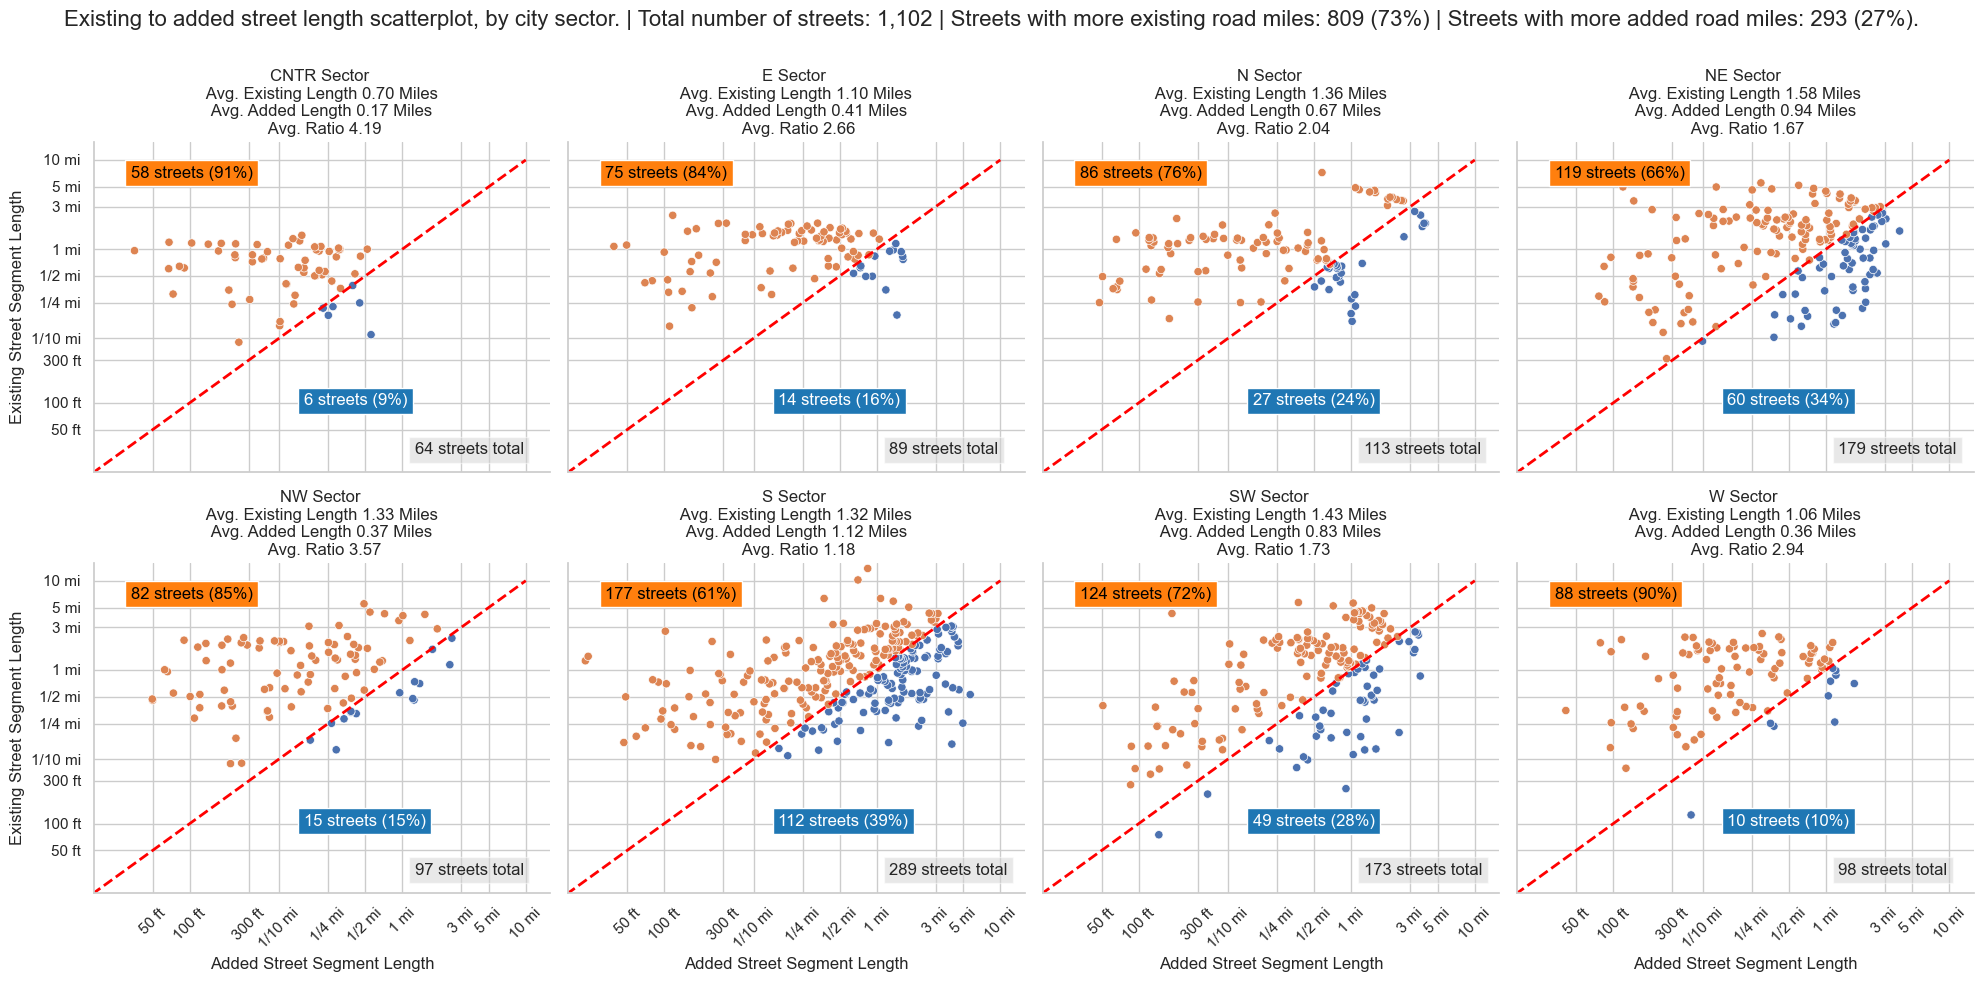

In [193]:
# make the plot
g = sns.FacetGrid(pv_df, col="city_sector", col_wrap=4, height=5, aspect=1)
g.map_dataframe(sns.scatterplot, x="added_street_within_sector_log", y="discontinuous_street_log",
                hue = 'street_ratio_dta_hue')

# Add a red diagonal line at unity
def draw_diagonal(*args, **kwargs):
    plt.plot([-3, 1], [-3, 1], color='red', linestyle='--', linewidth=2)

g.map(draw_diagonal)

g.set(xlim=(-2.5,1.2), ylim=(-2.5,1.2))
g.set_axis_labels("Added Street Segment Length", "Existing Street Segment Length")
#g.set_titles(col_template="{col_name}")

# x axis
x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1, 3, 5, 10]
x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi', '3 mi', '5 mi', '10 mi']
x_ticks = [np.log10(xtl) for xtl in x_tick_labels]

# y axis
y_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1, 3, 5, 10]
y_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi', '3 mi', '5 mi', '10 mi']
y_ticks = [np.log10(ytl) for ytl in y_tick_labels]


for ax in g.axes.flat:
    #print(dir(ax))
    
    # x axis
    ax.set_xticks(ticks = x_ticks)
    ax.set_xticklabels(labels = x_tick_label_text, rotation=45)    

    # y axis
    ax.set_yticks(ticks = y_ticks)
    ax.set_yticklabels(labels = y_tick_label_text, rotation=0)    
    
    # titles
    curr_cs = ax.get_title()[len('city_sector = '):]
    #print(curr_title)
    
    # the average ratio of added to existing streets
    curr_sctr_df = sctr_df.loc[sctr_df['city_sector']==curr_cs, :]
    avg_added = f'{curr_sctr_df['added_avg_length'].iloc[0]:,.2f}'
    avg_existing = f'{curr_sctr_df['existing_avg_length'].iloc[0]:,.2f}'
    avg_ratio = f'{curr_sctr_df['street_ratio_dta'].iloc[0]:,.2f}'

    curr_title = f"{curr_cs} Sector \n Avg. Existing Length {avg_existing} Miles \n Avg. Added Length {avg_added} Miles \n Avg. Ratio {avg_ratio}"
    ax.set_title(curr_title)

    # the number of streets with more added length than existing length and vice-versa
    added_streets = curr_sctr_df['added_is_gt'].iloc[0]
    existing_streets = curr_sctr_df['existing_is_gt'].iloc[0]
    total_streets = curr_sctr_df['total_streets'].iloc[0]
    added_streets_per = f'{curr_sctr_df['added_is_gt_per'].iloc[0]:.0%}'
    existing_streets_per = f'{curr_sctr_df['existing_is_gt_per'].iloc[0]:.0%}'

    existing_text = f"{existing_streets} streets ({existing_streets_per})"
    ax.text(x = -2.2, y = .8, s = existing_text, color = 'black', bbox = {'fc':'tab:orange', 'alpha':1})

    added_text = f"{added_streets} streets ({added_streets_per})"
    ax.text(x = -.8, y = -1.75, s = added_text, color = 'white', bbox = {'fc':'tab:blue', 'alpha':1})

    # total streets
    total_text = f"{total_streets} streets total"
    ax.text(x = .1, y = -2.3, s = total_text, bbox = {'fc':'lightgrey','alpha':.5})


tot_values = sctr_df.loc[sctr_df['city_sector'] == 'City Wide', :]

existing_streets = tot_values['existing_is_gt'].iloc[0]
existing_streets_per = tot_values['existing_is_gt_per'].iloc[0]
added_streets = tot_values['added_is_gt'].iloc[0]
added_streets_per = tot_values['added_is_gt_per'].iloc[0]
total_streets = tot_values['total_streets'].iloc[0]


title_text = f"""Existing to added street length scatterplot, by city sector. | Total number of streets: {total_streets:,} | Streets with more existing road miles: {existing_streets} ({existing_streets_per:.0%}) | Streets with more added road miles: {added_streets} ({added_streets_per:.0%}).
"""


g.figure.suptitle(t = title_text,
                  fontsize = 16)

# Adjust layout
plt.tight_layout()

output_file_name = '..\\graphics\\scatterplot_existing_added_segment_ratio.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
plt.savefig(fname = output_file_name)
plt.show()

# q14: tabulate and rank street length

In [194]:
# write to excel for, checking
pv_df.to_excel(excel_writer='check_ranks.xlsx', index = False)

In [195]:
# load the geospatial data
gdf.shape

(29776, 20)

In [196]:
pv_df.head()

,city_sector,ord_stname_concat,added_street_within_sector,discontinuous_street,total_length,added_street_within_sector_per,discontinuous_street_per,street_ratio_dta,street_ratio_atd,discontinuous_street_log,added_street_within_sector_log,street_ratio_dta_rank,ds_per_rank,street_ratio_atd_rank,asws_per_rank,record_count,street_ratio_dta_hue,street_ratio_dta_colors
0,CNTR,COMSTOCK ST,0.556985,0.109835,0.666820,0.835285,0.164715,0.197197,5.071083,-0.959257,-0.254157,64,64,1,1,1,0,#ca0020
1,CNTR,39TH AVE,0.450590,0.249468,0.700059,0.643646,0.356354,0.553648,1.806202,-0.602984,-0.346218,63,63,2,2,1,0,#ca0020
2,CNTR,TERRACE ST,0.250940,0.180963,0.431902,0.581010,0.418990,0.721140,1.386694,-0.742411,-0.600431,62,62,3,3,1,0,#ca0020
3,CNTR,RANDOLPH AVE,0.273631,0.226598,0.500229,0.547011,0.452989,0.828115,1.207561,-0.644744,-0.562835,61,61,4,4,1,0,#ca0020
4,CNTR,SMITH ST,0.227889,0.218018,0.445906,0.511068,0.488932,0.956686,1.045275,-0.661508,-0.642278,60,60,5,5,1,0,#ca0020


In [197]:
street_rank_df = pv_df[['city_sector', 'ord_stname_concat', 
                        'added_street_within_sector_per',
                        'discontinuous_street_per',                        
                        'street_ratio_dta_rank', 'street_ratio_atd_rank']].copy()

In [198]:
outcome = pd.merge(left = gdf, right = street_rank_df, how = 'left')

In [199]:
outcome['street_status'].value_counts()

street_status
1    21938
0     3812
2     3616
3      410
Name: count, dtype: int64

In [200]:
outcome['street_status_desc'].value_counts()

street_status_desc
discontinuous_street           21938
continuous_street               3812
added_street: within-sector     3616
added_street: cross-sector       410
Name: count, dtype: int64

In [201]:
# the ord_stname_concat_rank variable is only for within-sector existing and added streets
ss_recode = {0:-1, 1:-2, 2:-3, 3:-4}
for ss, oscr in ss_recode.items():
    outcome.loc[(outcome['street_status'] == ss) & 
                (outcome['street_ratio_atd_rank'].isna()), 'street_ratio_atd_rank'] = oscr
    print(outcome['street_ratio_atd_rank'].isna().value_counts())

    outcome.loc[(outcome['street_status'] == ss) & 
                (outcome['street_ratio_dta_rank'].isna()), 'street_ratio_dta_rank'] = oscr
    print(outcome['street_ratio_dta_rank'].isna().value_counts())


street_ratio_atd_rank
False    27485
True      2291
Name: count, dtype: int64
street_ratio_dta_rank
False    27485
True      2291
Name: count, dtype: int64
street_ratio_atd_rank
False    29366
True       410
Name: count, dtype: int64
street_ratio_dta_rank
False    29366
True       410
Name: count, dtype: int64
street_ratio_atd_rank
False    29366
True       410
Name: count, dtype: int64
street_ratio_dta_rank
False    29366
True       410
Name: count, dtype: int64
street_ratio_atd_rank
False    29776
Name: count, dtype: int64
street_ratio_dta_rank
False    29776
Name: count, dtype: int64


In [202]:
write_gdf(gdf = outcome, output_file_path=rc.OUTPUT_FILE_PATH,
          output_file_name='ranked_streets.gpkg')

In [203]:
pv_df.columns

Index(['city_sector', 'ord_stname_concat', 'added_street_within_sector',
       'discontinuous_street', 'total_length',
       'added_street_within_sector_per', 'discontinuous_street_per',
       'street_ratio_dta', 'street_ratio_atd', 'discontinuous_street_log',
       'added_street_within_sector_log', 'street_ratio_dta_rank',
       'ds_per_rank', 'street_ratio_atd_rank', 'asws_per_rank', 'record_count',
       'street_ratio_dta_hue', 'street_ratio_dta_colors'],
      dtype='object')

In [224]:
# select just the top five streets
col_names = ['city_sector',
             'ord_stname_concat', 
             'discontinuous_street',
             'added_street_within_sector',
             'total_length',
             'discontinuous_street_per',
             'added_street_within_sector_per', 
             'street_ratio_dta',
             'street_ratio_dta_rank',
             'street_ratio_atd',
             'street_ratio_atd_rank']
t5r_df = pv_df.loc[pv_df['street_ratio_atd_rank'].between(left = 1, right = 5, inclusive = 'both'), col_names].reset_index(drop = True)

# sort
t5r_df = t5r_df.sort_values(by = ['city_sector', 'street_ratio_atd_rank'])

# rename
col_names = ['City Sector',
             'Street',
             'Existing Miles',
             'Added Miles',
             'Total Miles',
             'Existing Percent',
             'Added Percent', 
             'Existing-to-Added Ratio',
             'E-to-A Rank',
             'Added-to-Existing Ratio',
             'Added-to-Existing Rank']
t5r_df.columns = col_names

# final selection
col_names = ['City Sector',
             'Street',
             'Added-to-Existing Rank',
             'Existing Miles',
             'Added Miles',
             'Total Miles',
             'Existing Percent',
             'Added Percent',              
             'Added-to-Existing Ratio'
             ]

t5r_df = t5r_df[col_names]

In [225]:

t5r_df['Existing Percent'] = t5r_df['Existing Percent'].map(lambda x: f"{x:0.2%}")
t5r_df['Added Percent'] = t5r_df['Added Percent'].map(lambda x: f"{x:0.2%}")

In [226]:
print(t5r_df.to_markdown(floatfmt=".2f", 
                         colalign=("right", "right", "center","right","right","right","right","right","right"),
                         index = False)
)                        

|   City Sector |         Street |  Added-to-Existing Rank  |   Existing Miles |   Added Miles |   Total Miles |   Existing Percent |   Added Percent |   Added-to-Existing Ratio |
|--------------:|---------------:|:------------------------:|-----------------:|--------------:|--------------:|-------------------:|----------------:|--------------------------:|
|          CNTR |    COMSTOCK ST |            1             |             0.11 |          0.56 |          0.67 |             16.47% |          83.53% |                      5.07 |
|          CNTR |       39TH AVE |            2             |             0.25 |          0.45 |          0.70 |             35.64% |          64.36% |                      1.81 |
|          CNTR |     TERRACE ST |            3             |             0.18 |          0.25 |          0.43 |             41.90% |          58.10% |                      1.39 |
|          CNTR |   RANDOLPH AVE |            4             |             0.23 |          0.27 |    